In [53]:
import os
import torch
import datasets

import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer, util
from transformers import BertTokenizer, BertForTokenClassification, pipeline

print(f"Torch version: {torch.__version__}")

Torch version: 2.4.0+cu121


In [54]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
from sentence_transformers import SentenceTransformer, InputExample, SentencesDataset, losses
from torch.utils.data import DataLoader

# Load or initialize the model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Create a minimal corpus
corpus = ["This is a test sentence.", "This is another test sentence."]

# Create input examples
def create_input_examples(corpus):
    examples = []
    for i in range(len(corpus)):
        for j in range(i + 1, len(corpus)):
            label = 1.0 if corpus[i] == corpus[j] else 0.0
            examples.append(InputExample(texts=[corpus[i], corpus[j]], label=label))
    return examples

train_examples = create_input_examples(corpus)

# Create DataLoader
train_dataset = SentencesDataset(train_examples, model)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

# Define loss function
train_loss = losses.CosineSimilarityLoss(model=model)

# Train the model
try:
    model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        epochs=1,
        warmup_steps=1,
        output_path='/tmp/test-model'
    )
except Exception as e:
    print(f"An error occurred during training: {e}")


/home/ydepledt/py_env/hugging_face/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


An error occurred during training: 'NoneType' object has no attribute 'float'


In [43]:
path_to_similarity_model  = '/home/ydepledt/model/sentence-transformers/all-MiniLM-L6-v2'
path_to_ner_model = '/home/ydepledt/model/dbmdz/bert-large-cased-finetuned-conll03-english'


# Load or initialize SentenceTransformer model
if os.path.isdir(path_to_similarity_model):
    similarity_model = SentenceTransformer(path_to_similarity_model)
    print(f"Loaded sentence similarity model from {path_to_similarity_model}")
else:
    similarity_model = SentenceTransformer('all-MiniLM-L6-v2')
    similarity_model.save(path_to_similarity_model)
    print(f"Saved sentence similarity model to {path_to_similarity_model}")

# Load or initialize NER model
if os.path.isdir(path_to_ner_model):
    ner_model = BertForTokenClassification.from_pretrained(path_to_ner_model)
    tokenizer = BertTokenizer.from_pretrained(path_to_ner_model)
    print(f"Loaded NER model from {path_to_ner_model}")
else:
    ner_model = BertForTokenClassification.from_pretrained('dbmdz/bert-large-cased-finetuned-conll03-english')
    tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-large-cased-finetuned-conll03-english')
    ner_model.save_pretrained(path_to_ner_model)
    tokenizer.save_pretrained(path_to_ner_model)
    print(f"Saved NER model to {path_to_ner_model}")

Loaded sentence similarity model from /home/ydepledt/model/sentence-transformers/all-MiniLM-L6-v2
Loaded NER model from /home/ydepledt/model/dbmdz/bert-large-cased-finetuned-conll03-english


In [44]:
with open('./corpus.txt', 'r') as f:
    corpus = f.readlines()

corpus = [corp[:-2] for corp in corpus if corp != '\n']

In [45]:
embeddings = similarity_model.encode(corpus, show_progress_bar=True)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [46]:
nlp_ner = pipeline('ner', model=ner_model, tokenizer=tokenizer, device=device)

ner_results = [nlp_ner(corp) for corp in corpus]

In [47]:
similarity_matrix = util.pytorch_cos_sim(embeddings, embeddings)

<Axes: >

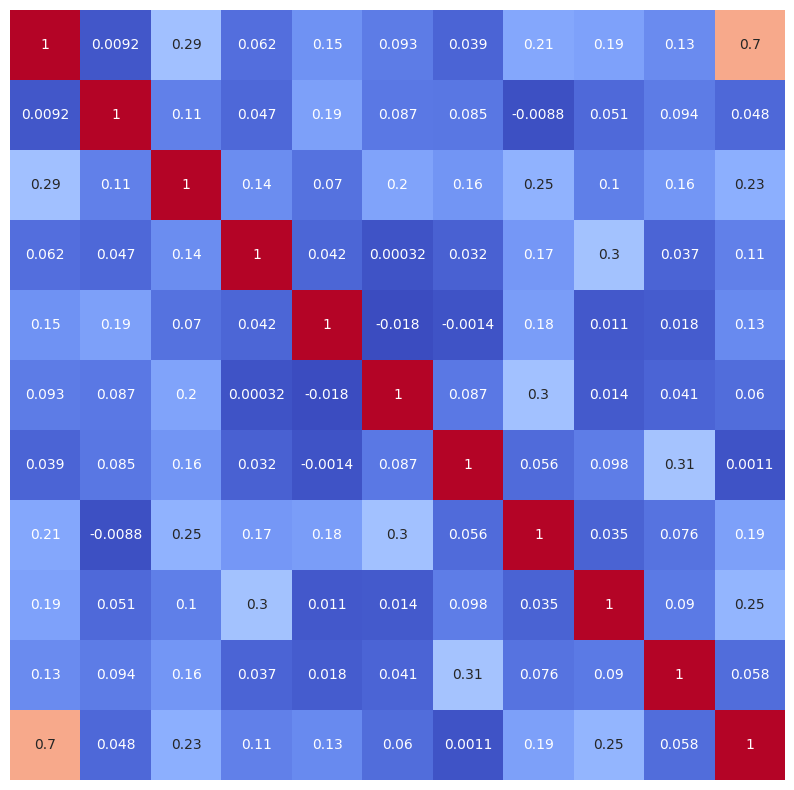

In [48]:
dict_order = {i: corpus[i] for i in range(len(corpus))}

plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', xticklabels=False, yticklabels=False, cbar=False)

In [49]:
for i, result in enumerate(ner_results):
    print(f"Text: {corpus[i]}")
    for entity in result:
        print(f"Entity: {entity['word']} | Label: {entity['entity']} | Score: {entity['score']:.4f}")
    print()

Text: Space exploration has always captured human imagination. From the first moon landing in 1969 to the recent Mars rover missions, the quest to understand our universe continues to drive scientific advancement and inspire innovation
Entity: Mars | Label: I-MISC | Score: 0.7191

Text: Italian cuisine is renowned for its rich flavors and simple, fresh ingredients. Dishes like pasta, pizza, and risotto highlight the emphasis on quality produce and traditional cooking techniques that define this culinary tradition
Entity: Italian | Label: I-MISC | Score: 0.9988

Text: Artificial intelligence (AI) has made tremendous strides in recent years, with applications ranging from natural language processing to autonomous vehicles. These advancements are reshaping industries and influencing daily life in unprecedented ways
Entity: AI | Label: I-MISC | Score: 0.8915

Text: Coastal cities around the world are facing increasing risks due to climate change. Rising sea levels, more frequent storms, an